In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import os

# 1. Twitter tennis datasets

We compiled two separate tweet collections, `RG17` for **Roland-Garros 2017**, the French
Open Tennis Tournament, and `uo17` for **US Open 2017**, the United States Open Tennis
Championship.

## Data collection

- We gathered data with the Twitter Search API, by using the following two separate sets of keywords:

```
{@rolandgarros, #RolandGarros2017,
#rolandgarros2017, #RolandGarros, #rolandgarros,
#FrenchOpen, #frenchopen, #RG17, #rg17}

{#usopen, #Usopen, #UsOpen, #USOPEN,
#usopen17, #UsOpen17, #Usopen2017, @usopen,
#WTA, #wta, #ATP, #atp, @WTA, @ATPWorldTour,
#Tennis, #tennis, #tenis, #Tenis}
```

**NOTE:** retweets were excluded from these datasets

## Event timeline

- **Qualifications:**
   - RG17: 2017-05-22 -> 2017-05-26 (we collected data only from 2017-05-24)
   - UO17: 2017-08-22 -> 2017-08-25
- **Days without tournaments:**
   - RG17: 2017-05-27
   - UO17: 2017-08-26 -> 2017-08-27
- **Main tournaments:** used for supervised model evaluation
   - RG17: 2017-05-28 -> 2017-06-11 (15 days)
   - UO17: 2017-08-28 -> 2017-09-10 (14 days)
   
## Dataset preparation

In [3]:
from online_node2vec.data.tennis_handler import download_data_set
data_dir = "../data"
dataset_id = "rg17"

In [4]:
preproc_dir, handler = download_data_set(data_dir, dataset_id)
print("Path for preprocessed data:", preproc_dir)

{'data_id': 'rg17', 'include_qualifiers': True, 'dates': ['2017-05-24', '2017-05-25', '2017-05-26', '2017-05-27', '2017-05-28', '2017-05-29', '2017-05-30', '2017-05-31', '2017-06-01', '2017-06-02', '2017-06-03', '2017-06-04', '2017-06-05', '2017-06-06', '2017-06-07', '2017-06-08', '2017-06-09', '2017-06-10', '2017-06-11'], 'dates_with_no_game': ['2017-05-27'], 'start_time': 1495576800, 'end_time': 1497218400, 'number_of_edges': 336234, 'number_of_nodes': 78095}
Exporting files STARTED
2017-05-24 66
2017-05-25 43
2017-05-26 34
2017-05-27 0
2017-05-28 60
2017-05-29 118
2017-05-30 138
2017-05-31 194
2017-06-01 148
2017-06-02 120
2017-06-03 83
2017-06-04 116
2017-06-05 81
2017-06-06 71
2017-06-07 96
2017-06-08 64
2017-06-09 57
2017-06-10 33
2017-06-11 18
Exporting files DONE
Path for preprocessed data: ../data/rg17_preprocessed


### Edge stream

- **Nodes:** Twitter accounts
- **Edges:** 
   - @-mentions between accounts
   - timestamp is extracted from the tweet

In [5]:
edges = np.loadtxt(os.path.join(preproc_dir, "edges.csv"), delimiter="|", max_rows=5)
print(edges)

[[1.49557681e+09 3.42138386e+09 3.42138386e+09]
 [1.49557683e+09 1.09918332e+08 3.49926440e+07]
 [1.49557683e+09 1.09918332e+08 5.03355910e+07]
 [1.49557684e+09 4.13885197e+08 4.22203530e+07]
 [1.49557684e+09 4.13885197e+08 7.19754460e+07]]


Text(0.5, 1.0, 'RG17')

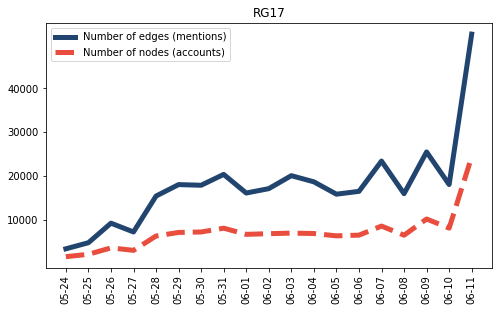

In [7]:
fig = handler.visualize(kind="graph", figsize=(8,5))
fig.axes[0].set_title("RG17")

Number of nodes and edges in the RG17 mention graph. 
- During the qualifiers the number of interactions is low. 
- Then user activity increases as the championship starts from May 28  
- Activity burst due to Men’s Singles finals on June 7–9–11

### Tennis player accounts on Twitter

One of the most time-consuming parts of our measurement was to assign Twitter
accounts to tennis players. 

- The total number of professional participants for Roland-Garros is 698. Unfortunately, many of the players have no Twitter accounts.

- We assigned players to accounts by the Twitter Search API’s people endpoint; however, the API was sometimes unable to identify the accounts of the active players.

### Node relevance labels

- An account in the Twitter mention graph is **relevant** if it corresponds to a tennis player that participated in the tournaments of the given day
- Node relevance labels change from day to day based on the official schedule of the tournaments.

#### Official event schedule

In [60]:
handler.schedule.head()

,day,date,courtName,orderNumber,matchHeader,startDate,playerName active,playerName opponent,matchScore
0,Qualifying Day 1,2017-05-22,Court 6,1,Qualifying Men's Singles - Round 1,10:00 AM,Laslo Djere,Benjamin Becker,6-2 2-6 6-3
1,Qualifying Day 1,2017-05-22,Court 6,2,Qualifying Men's Singles - Round 1,10:00 AM,Reilly Opelka,Daniel Munoz De La Nava,4-6 7-6(4) 6-4
2,Qualifying Day 1,2017-05-22,Court 6,3,Qualifying Men's Singles - Round 1,10:00 AM,Marius Copil,Denis Shapovalov,6-0 4-6 6-2
3,Qualifying Day 1,2017-05-22,Court 6,4,Qualifying Men's Singles - Round 1,10:00 AM,Paul-Henri Mathieu,Tatsuma Ito,6-7(0) 6-2 6-2
4,Qualifying Day 1,2017-05-22,Court 6,5,Qualifying Men's Singles - Round 1,10:00 AM,Casper Ruud,Yannik Reuter,6-3 6-2


#### Supervised evaluation
   - binary node labels (daily player or not?)
   - for the main tournaments: 2017-05-28 -> 2017-06-11 (15 days)

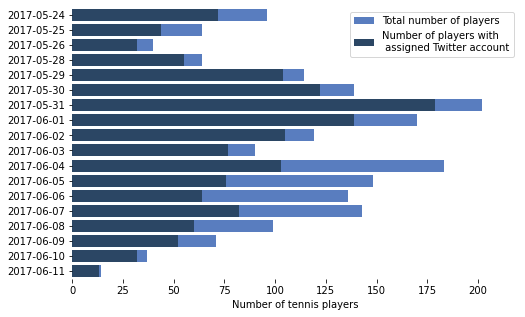

Text(0.5, 1.0, 'RG17')

In [8]:
fig = handler.visualize(kind="players", figsize=(8,5))
fig.axes[0].set_title("RG17")

#### Label file format

In [9]:
players_in_finals = np.loadtxt(os.path.join(preproc_dir, "labels_18.csv"), delimiter=" ")
print("Found relevant players on the last day:", len(players_in_finals))

Found relevant players on the last day: 18


In [10]:
print(players_in_finals[:5])

[[1.78612820e+07 1.00000000e+00]
 [6.51870670e+07 1.00000000e+00]
 [7.41460950e+07 1.00000000e+00]
 [1.10398012e+08 1.00000000e+00]
 [1.90989915e+08 1.00000000e+00]]


# 2. Online node embeddings

## i.) Initialize models

Our online node embedding algorithms have two components:

- **updater:** sample node pairs for representation learning
- **learner:** online Word2Vec implementation

In [11]:
from online_node2vec.online.walk_sampling import StreamWalkUpdater
from online_node2vec.online.walk_sampling import SecondOrderUpdater
from online_node2vec.online.w2v_learners import OnlineWord2Vec

### a.) StreamWalk

**Updater parameters:**

- half_life : Half-life in seconds for time decay
- max_len : Maximum length of the sampled temporal random walks
- beta : Damping factor for long paths
- k: Number of sampled walks for each edge update

In [12]:
sw_updater = StreamWalkUpdater(
    half_life=7200, 
    max_len=2, 
    beta=0.9, 
    k=4,
)    

**Learner parameters:**

- embedding_dims :Dimensions of the representation
- lr_rate : Learning rate
- neg_rate: Negative rate
- mirror: Feed sampled node pairs in both order to the learner
- exportW1: bool

In [13]:
dimensions = 128

In [14]:
sw_learner = OnlineWord2Vec(
    embedding_dims=dimensions, 
    lr_rate=0.035, 
    neg_rate=10, 
    mirror=False, 
    exportW1=False, 
)

In [15]:
from online_node2vec.online.online_node2vec_models import LazyNode2Vec

In [16]:
streamwalk = LazyNode2Vec(sw_updater, sw_learner, is_decayed=True)

Model was INITIALIZED: lazy_decayedTrue-streamwalk_hl7200_ml2_beta0.90_cutoff604800_k4_fullwFalse-onlinew2v_dim128_lr0.0350_neg10_uratio1.00_square_mirrorFalse_omFalse_inituniform_expW1False_i86400_tnFalse_win2_pairsTrue


### b.) Online second order similarity

**Updater parameters:**

- half_life : Half-life in seconds for time decay
- num_hash : Number of hash functions to use for similarity approximation
- hash_gen : Hash function generator class.

In [17]:
from online_node2vec.online.hash_utils import ModHashGenerator
so_updater = SecondOrderUpdater(
    half_life=43200,
    num_hash=20,
    hash_generator=ModHashGenerator()
)

**Learner parameters:**

- uniform_ratio: Fraction of uniform random negative samples. Remaining negative samples are chosen from past positive training instances.

In [18]:
so_learner = OnlineWord2Vec(
    embedding_dims=dimensions, 
    lr_rate=0.01, 
    neg_rate=20, 
    uniform_ratio=0.8,
)

In [19]:
second_order = LazyNode2Vec(so_updater, so_learner, is_decayed=True)

Model was INITIALIZED: lazy_decayedTrue-secondorder_hl43200_numh20_modhash200000_in0.00_out1.00_incrTrue-onlinew2v_dim128_lr0.0100_neg20_uratio0.80_square_mirrorTrue_omFalse_inituniform_expW1True_i86400_tnFalse_win2_pairsTrue


## ii.) Run models

In [20]:
from online_node2vec.data.tennis_handler import load_edge_data

**Experiment setup:**
- node representations are
    - calculated for the first 3 days
    - exported in every 6 hours
- the total elapsed time and Word2Vec training time are shown in seconds

In [21]:
result_folder = "../results/"
total_days = 3
delta_time = 6*3600
root_dir = "%s/%s/features_%s/delta_%i" % (result_folder, dataset_id, 0, delta_time)

In [22]:
edge_data, start_time, end_time = load_edge_data(data_dir, dataset_id, total_days)

#### Calculate and export StreamWalk representations 

In [23]:
# Execution takes more time!
streamwalk_output_dir = streamwalk.run(edge_data, delta_time, root_dir, start_time=start_time, end_time=end_time)

Original number of edges: 336234
Number of edges after temporal filter: 51398
Number of edges after dropping loop edges: 51134
Number of nodes in the remaining data: 16412
Experiment was STARTED
0 1 0.9001266956329346
1 4 3.2552459239959717
2 12 10.01228141784668
3 17 14.480241775512695
Updating noise with 122920 records
4 20 15.631632328033447
5 24 17.738075017929077
6 33 24.666977882385254
7 41 30.13319706916809
8 44 31.33244276046753
Updating noise with 277416 records
9 48 33.2814998626709
10 58 39.7583065032959
11 68 46.41079092025757
Experiment was FINISHED


#### Calculate and export online second order similarity representations 

In [24]:
# Execution takes more time!
second_order_output_dir = second_order.run(edge_data, delta_time, root_dir, start_time=start_time, end_time=end_time)

Original number of edges: 336234
Number of edges after temporal filter: 51398
Number of edges after dropping loop edges: 51134
Number of nodes in the remaining data: 16412
Experiment was STARTED
0 5 4.565746068954468
1 17 16.46750521659851
2 37 34.339606046676636
3 53 47.29729604721069
Updating noise with 177102 records
4 59 51.53520894050598
5 68 58.900879859924316
6 92 79.36381387710571
7 112 94.76065015792847
8 120 100.47431969642639
Updating noise with 366532 records
9 128 105.7476065158844
10 149 122.03883862495422
11 170 138.03922295570374
Experiment was FINISHED


## iii.) Observe node representations over time

### Load label information

In [25]:
from online_node2vec.data.tennis_handler import get_data_info

In [26]:
gen_id_to_account, player_labels = get_data_info(os.path.join(data_dir, "%s_preprocessed" % dataset_id))

### Load node representations

In [27]:
from online_node2vec.data.n2v_embedding_handler import load_n2v_features

In [28]:
print(streamwalk_output_dir)

../results//rg17/features_0/delta_21600/lazy_decayedTrue-streamwalk_hl7200_ml2_beta0.90_cutoff604800_k4_fullwFalse-onlinew2v_dim128_lr0.0350_neg10_uratio1.00_square_mirrorFalse_omFalse_inituniform_expW1False_i86400_tnFalse_win2_pairsTrue


In [29]:
model_dirs = {
    "so":second_order_output_dir,
    "sw":streamwalk_output_dir
}

In [30]:
feature_sets = {}
for model_id in ["sw","so"]:
    feature_sets[model_id] = load_n2v_features(
        model_dirs[model_id], 
        delta_time, 
        total_days, 
        player_labels, 
        verbose=False
    )

0 12 1
0 12 1


### Animation: Tennis player account embedding

In [34]:
import plotly.express as px
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

def prepare_animation(player_labels, feature_set, delta_time, model_name, x=1, y=2, frame_duration=1000, transition_duration=500, verbose=False):
    player_nodes = list(pd.concat(player_labels)["id"].unique())
    if verbose:
        print("Number of tennis player accounts:", len(player_nodes))
    snapshot_per_day = int(86400/delta_time)
    num_snapshots = len(feature_set)
    embeddings = []
    for i in range(num_snapshots):
        snap_relevant = list(player_labels[i//snapshot_per_day]["id"])
        snap_emb = feature_set[i][1].rename({0:"id"}, axis=1).copy()
        snap_emb = snap_emb[snap_emb["id"].isin(player_nodes)].copy()
        snap_emb["snapshot"] = i
        snap_emb["label"] = snap_emb["id"].apply(lambda x: 1.0 if x in snap_relevant else 0.0)
        embeddings.append(snap_emb)
        if verbose:
            print(len(snap_emb))
    embedding_df = pd.concat(embeddings).reset_index(drop=True)[["id","label","snapshot",x,y]]
    range_x=[embedding_df[x].min(), embedding_df[x].max()]
    range_y=[embedding_df[y].min(), embedding_df[y].max()]
    title = "%s representation over time for tennis player Twitter accounts (snapshots length: %i hours)" % (model_name, delta_time/3600)
    fig = px.scatter(embedding_df, x=x, y=y, animation_frame="snapshot", animation_group="id", color="label", hover_name="id", range_x=range_x, range_y=range_y)
    fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = frame_duration
    fig.layout.updatemenus[0].buttons[0].args[1]["transition"]["duration"] = transition_duration
    _ = fig.layout.update(
        title_text=title,
        title_font_size=18, 
        showlegend=False,
        coloraxis_showscale=False
    )
    return fig, embedding_df

In [35]:
fig_sw, embedding_sw = prepare_animation(player_labels, feature_sets["sw"], delta_time, "StreamWalk")
fig_so, embedding_so = prepare_animation(player_labels, feature_sets["so"], delta_time, "Online second order")

**Visualization notes:**
    
- **Nodes:** Twitter accounts of tennis players
    - **yellow:** players who play on the given day
    - **purple:** player who doesn't play on the given day
    - colors change from day to day (after every 4 snapshots)
    
- **Representations:**
    - initialized uniformly at random in a 128-dimensional space (close to the origo in snapshot=0)
    - updated online as @-mention arrive in the edge stream (we only show the first two coordinates)
    - performance is considered better when yellow nodes are mapped close to each other
- **Results:**
    - StreamWalk (with 2 hours half-time) efficiently capture daily players by the end of each day
    - Online second order similarity (with longer half-life) can also map daily players close to each other in the embedded space

In [36]:
fig_sw

In [37]:
fig_so

### Task: similarity search

**active account:** account `n` is active on the given day, if it belongs to a tennis player who participated in a completed, canceled, or resumed game.

We use [NDCG](https://en.wikipedia.org/wiki/Discounted_cumulative_gain) (Al-Maskari et al. 2007) to evaluate how other active accounts are similar
to a selected one. NDCG is a measure for ranked lists that assigns higher score if active
accounts appear with higher rank in the similarity list. 


In our experiments, we compute
the average of the **NDCG@100** for the active accounts as query nodes to measure the
performance of a single model in any given snapshot. **Dot product** is used to measure the similarity of node representations.

In [38]:
from online_node2vec.evaluation.ndcg_computer import parallel_eval_ndcg
from online_node2vec.evaluation.ndcg_computer import parallel_combined_eval_ndcg
from tqdm import tqdm

#### a.) Single model performance

In [39]:
metric = "-dot"
max_threads = 2
model_performance = {}
for model_id in ["sw","so"]:
    model_performance[model_id] = pd.concat(parallel_eval_ndcg(
        feature_sets[model_id], 
        gen_id_to_account, 
        metric,
        n_threads=max_threads
    ))

In [40]:
sw_ndcg = model_performance["sw"]["ndcg"].mean()
so_ndcg = model_performance["so"]["ndcg"].mean()

StreamWalk and online second order similarity have similar performance for the first 3 days

In [41]:
print("StreamWalk NDCG:", sw_ndcg)
print("Online second order NDCG:", so_ndcg)

StreamWalk NDCG: 0.28164779012711383
Online second order NDCG: 0.28871839721681763


#### b.) Combination of StreamWalk and online second order similarity

- StreamWalk and online second order similarity can learn different network properties from the edge stream. 
- We combined the output of StreamWalk and second order similarity by using the weighted average of the corresponding inner products as similarity. 
- The combined model (SW+SO) outperforms SW and SO. 
- The optimal weight of SO in the combination was 0.3 for the complete datasets

TODO: figs/tables from the paper

#### Combination on the first 3 days

In [54]:
weights = list(np.arange(0.1,1.1,0.1))

[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 1.0]


In [55]:
# Execution takes more time!
combination_performance = []
for second_order_weight in tqdm(weights):
    combination_performance.append(pd.concat(parallel_combined_eval_ndcg(
        feature_sets["so"], 
        feature_sets["sw"], 
        second_order_weight, 
        gen_id_to_account, 
        metric, 
        n_threads=max_threads
    )))

100%|██████████| 10/10 [10:52<00:00, 65.23s/it]


In [56]:
mean_ndcg = [sw_ndcg] + [perf["ndcg"].mean() for perf in combination_performance] + [so_ndcg]
so_weights = [0.0] + weights + [1.0]

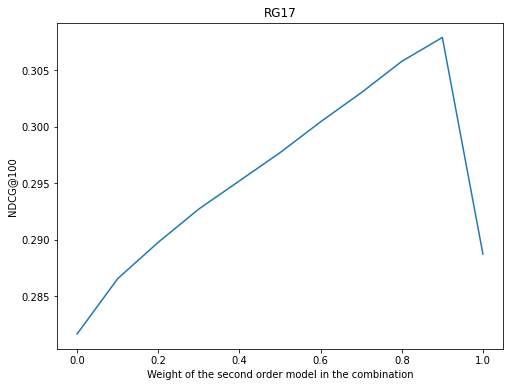

In [58]:
plt.figure(figsize=(8,6))
plt.plot(so_weights, mean_ndcg)
plt.title(dataset_id.upper())
plt.xlabel("Weight of the second order model in the combination")
plt.ylabel("NDCG@100")
plt.show()